In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [15]:
def get_counts(tensor):
    CLEAN_LABEL = 29907
    TOXIC_LABEL = 4986
    clean_count = (tensor == CLEAN_LABEL).sum().item()
    toxic_count = (tensor == TOXIC_LABEL).sum().item()
    total_count = tensor.numel()
    invalid_count = total_count - clean_count - toxic_count

    if invalid_count != 0:
        # raise ValueError("Invalid prediction during result generation!")
        print(f"Invalid predictions! {invalid_count} labels is not in {{CLEAN_LABEL, TOXIC_LABEL}}")

    return clean_count, toxic_count, invalid_count, total_count

def calculate_percentages(layer):
    pos_clean_percentages = []
    neg_clean_percentages = []

    for ic_key, ic in layer.items():
        clean_count, toxic_count, invalid_count, total_count = get_counts(ic["pos_preds"])
        # calculate with or without the invalid counts
        # pos_clean_percentages.append(clean_count / total_count)
        pos_clean_percentages.append(clean_count / (total_count - invalid_count))
        
        clean_count, toxic_count, invalid_count, total_count = get_counts(ic["neg_preds"])
        # calculate with or without the invalid counts
        # neg_clean_percentages.append(clean_count / total_count)
        neg_clean_percentages.append(clean_count / (total_count - invalid_count))
    
    return pos_clean_percentages, neg_clean_percentages

def plot_results(results, save_path, save=False, show=True):
    
    # get a string of all the injection coefficients 
    ic_keys = [str(i) for i in next(iter(next(iter(results.values())).values())).keys()]

    n_layers = len(next(iter(results.values())).keys())
    colors = cm.viridis(np.linspace(0, 1, n_layers))

    for position_key, position in results.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
        axes[0].set_ylim(0, 1.05)
        
        fig.suptitle(f"Position {position_key}", fontsize=14)
        fig.text(0.5, 0.04, 'Injection coefficients', ha='center', va='center')
        fig.text(0.06, 0.5, 'Percentage of sequences classified as clean', ha='center', va='center', rotation='vertical')

        for layer_key, layer in sorted(position.items()):
            pos_clean_percentages, neg_clean_percentages = calculate_percentages(layer)
            color = colors[layer_key - 5]  # Adjust based on actual layer_key mapping

            axes[0].plot(ic_keys, pos_clean_percentages, label=f"Layer {layer_key}",
                         alpha=0.7, color=color, marker='o', linewidth=2, markersize=4)
            axes[1].plot(ic_keys, neg_clean_percentages, label=f"Layer {layer_key}",
                         alpha=0.7, color=color, marker='o', linewidth=2, markersize=4)

        axes[0].set_title("Lenient persona sequence classifications")
        axes[1].set_title("Harsh persona sequence classifications")
        axes[0].set_xticks(range(len(ic_keys)))
        axes[0].set_xticklabels(ic_keys)
        axes[1].set_xticks(range(len(ic_keys)))
        axes[1].set_xticklabels(ic_keys)

        # Create a custom legend outside the plot to make it more clear
        custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_layers)]
        fig.legend(custom_lines, [f"Layer {i+5}" for i in range(n_layers)], loc='center right', borderaxespad=0.1)
        
        plt.subplots_adjust(right=0.85)
        if save: 
            fig.savefig(f"{save_path}position_{position_key}")
        if show: 
            plt.show()

        plt.close()

        # To display only the first layer, uncomment the following line
        # break

-------
Persona results
-------


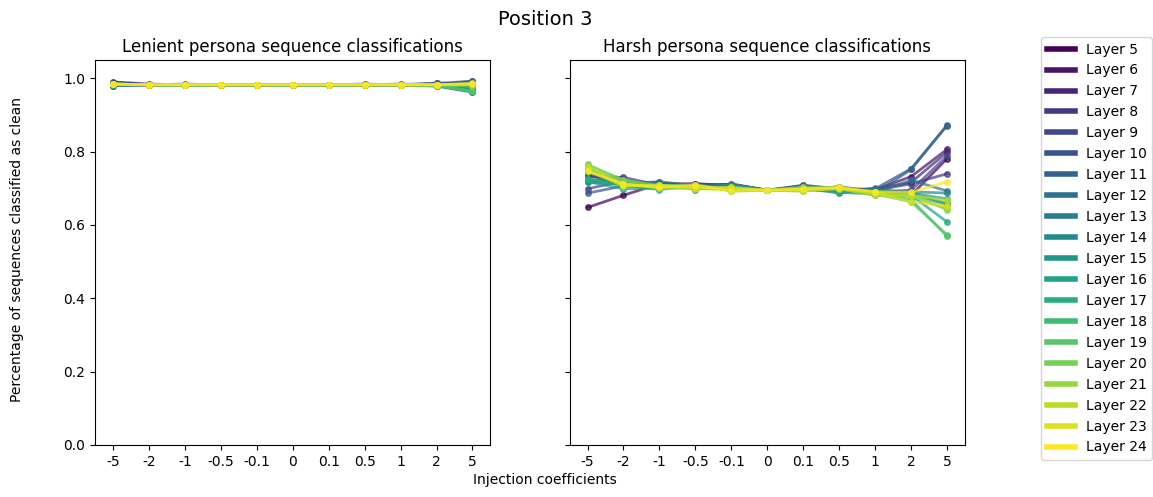

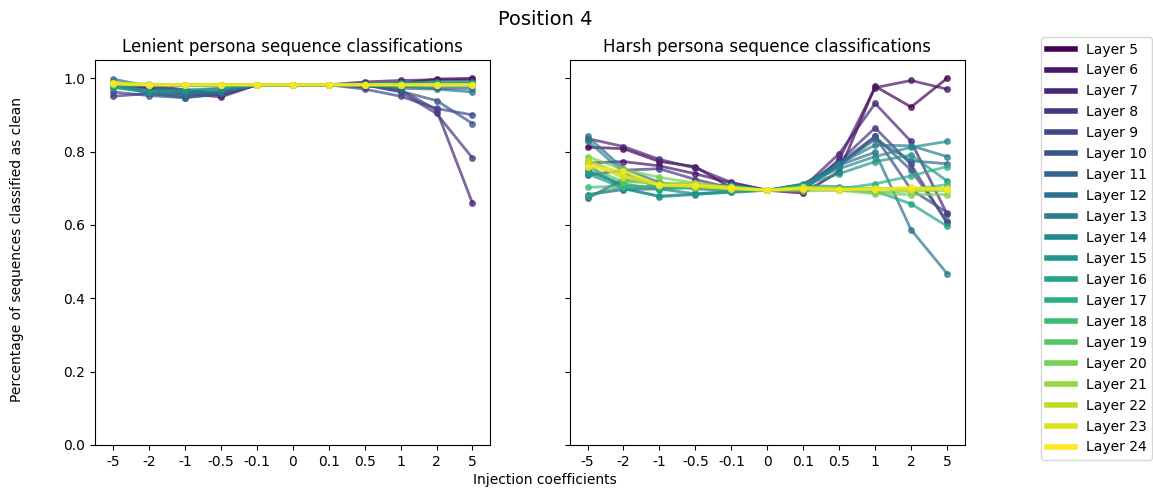

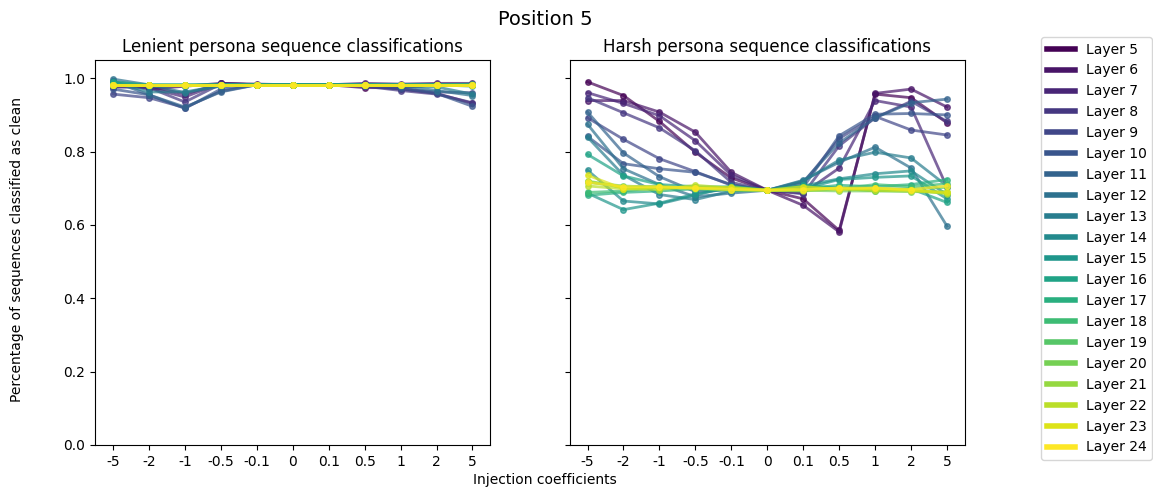

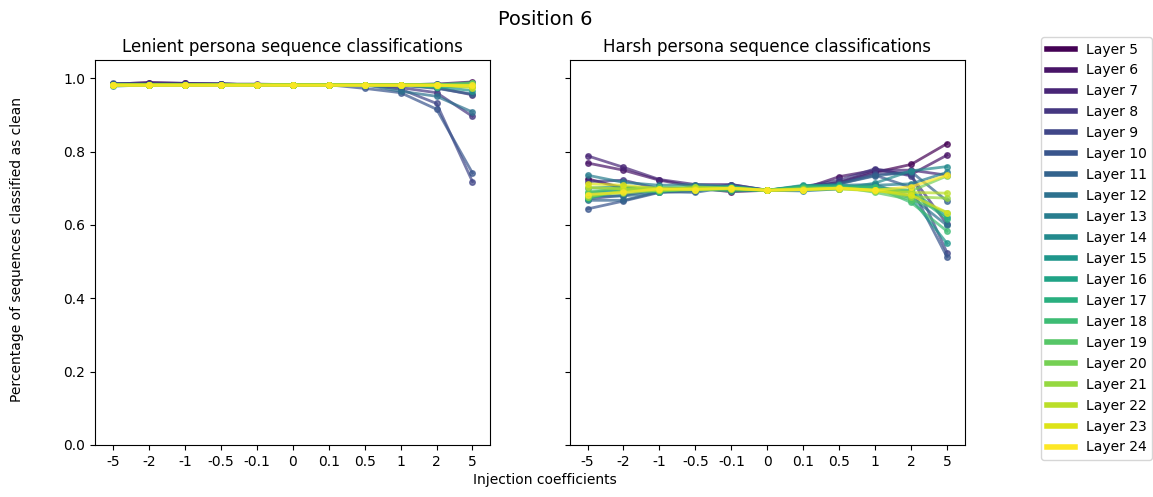

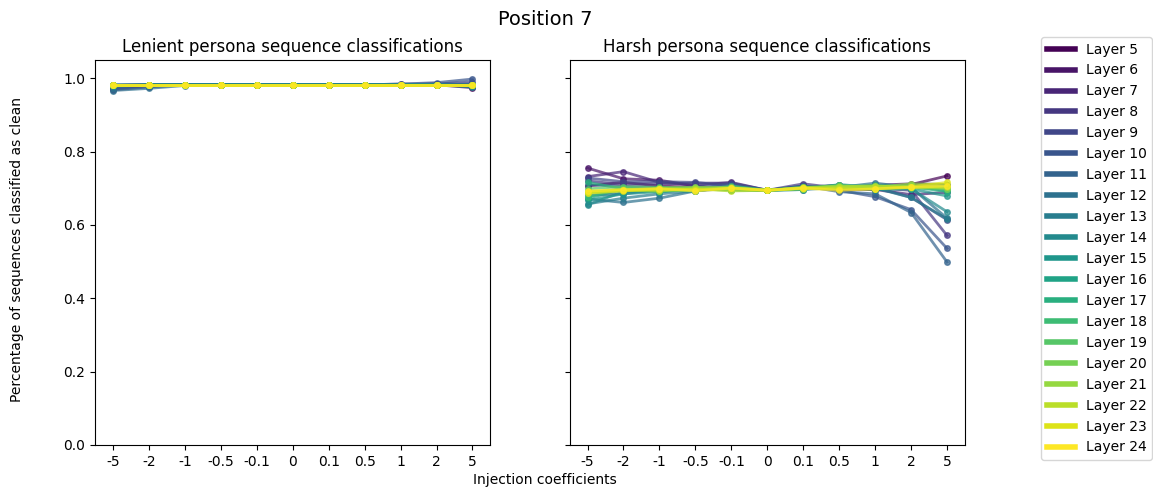

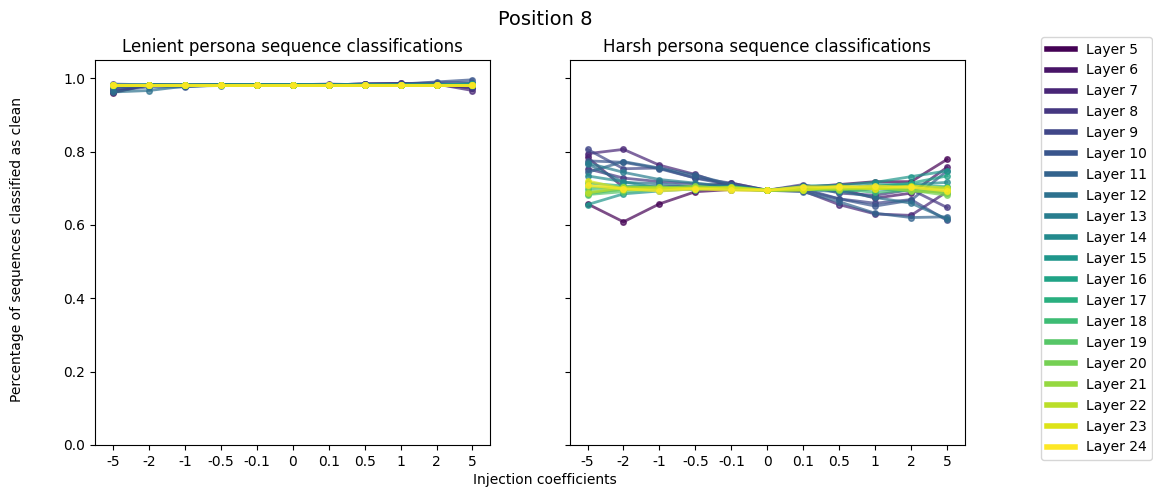

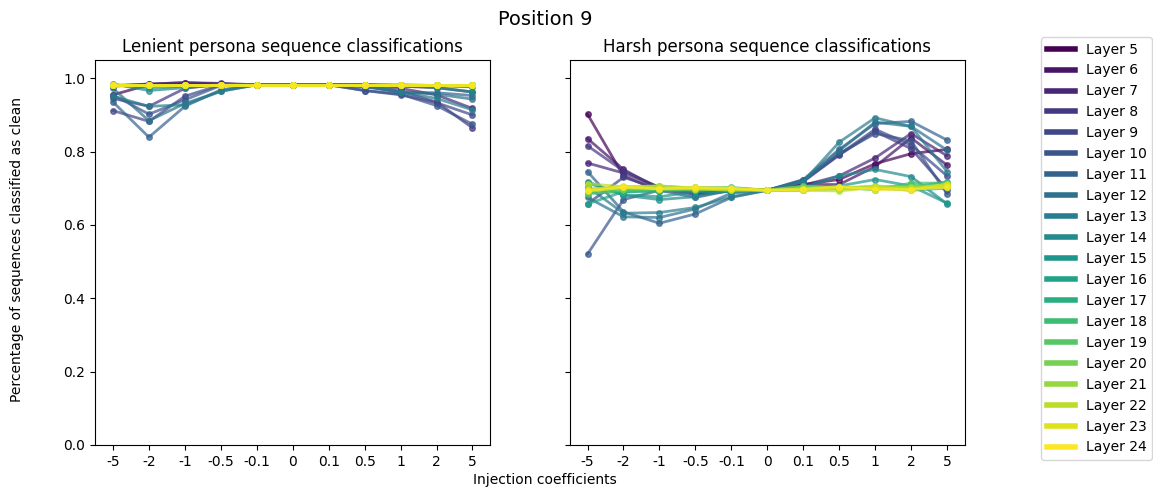

-------
Lenient results
-------


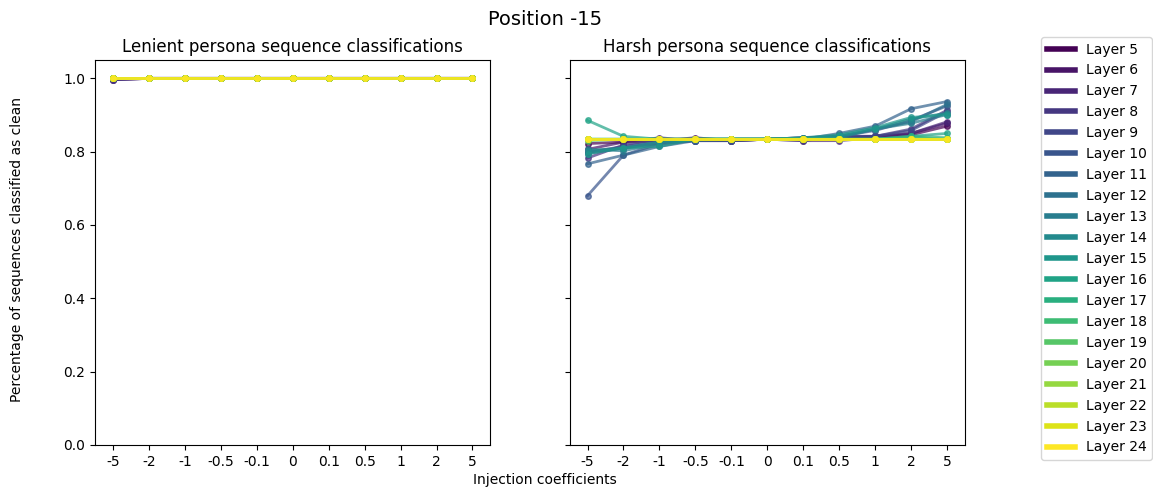

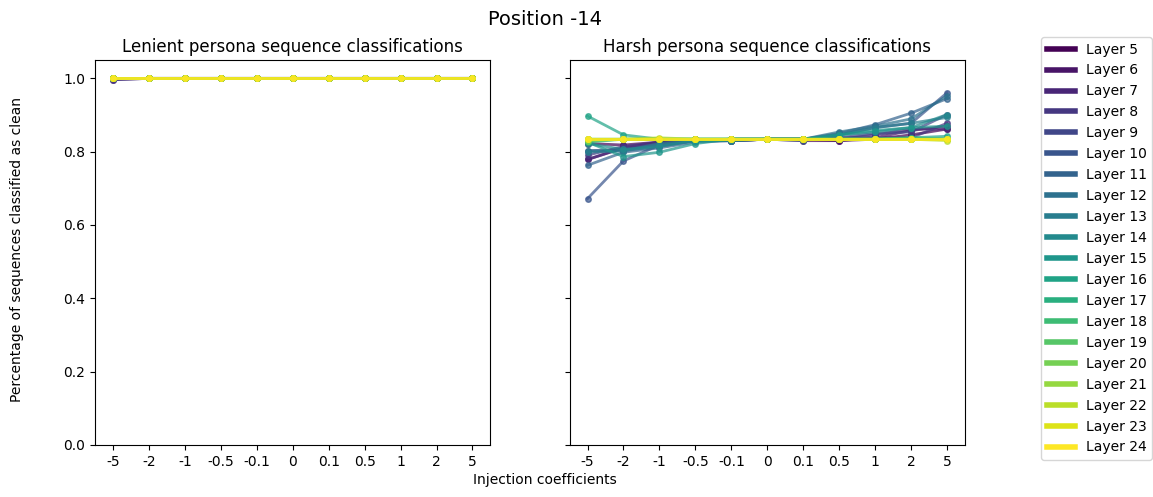

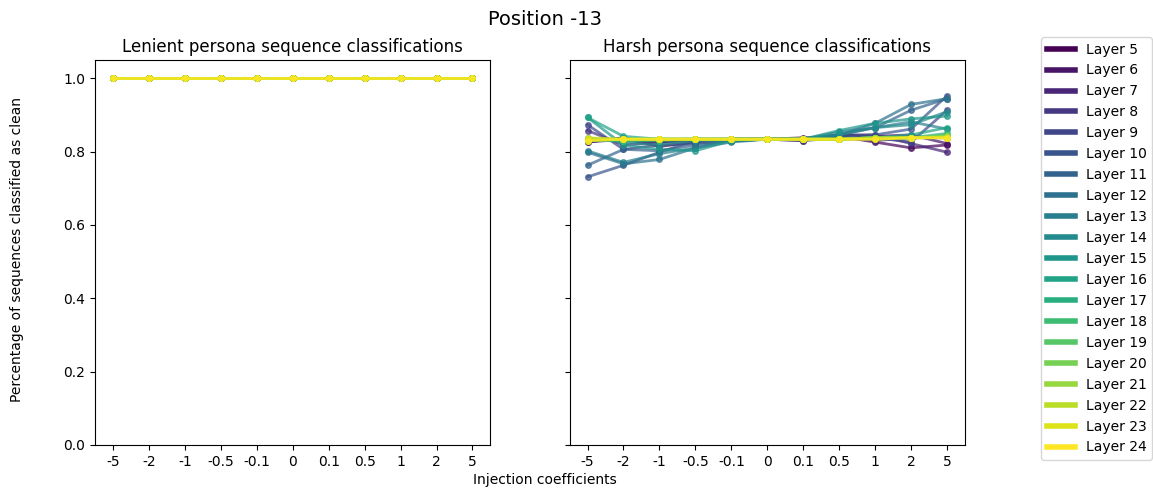

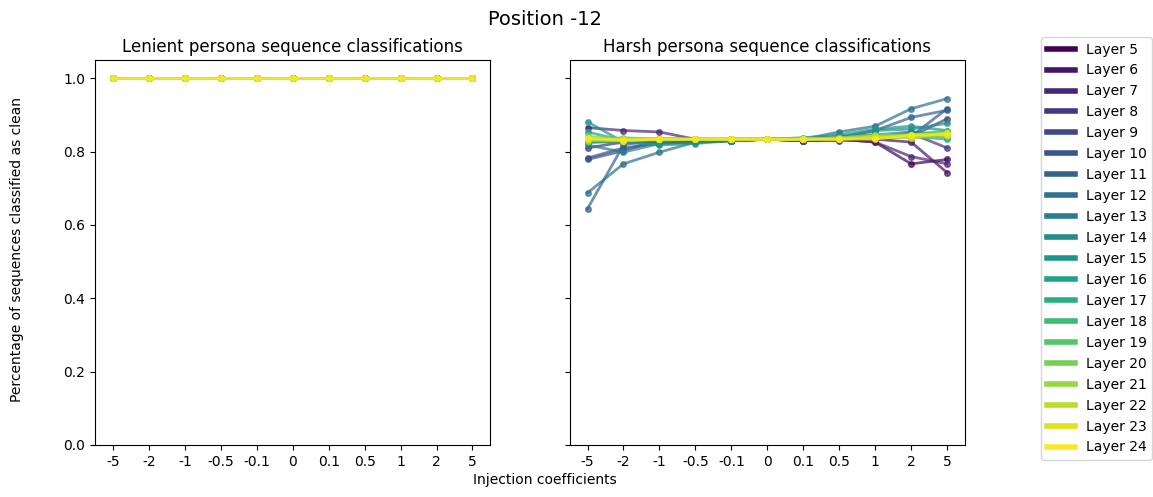

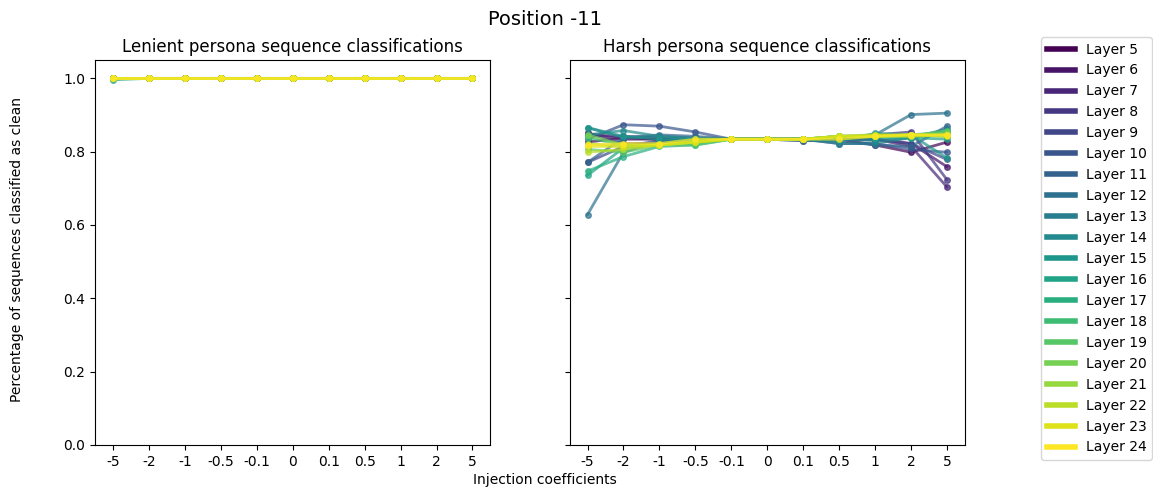

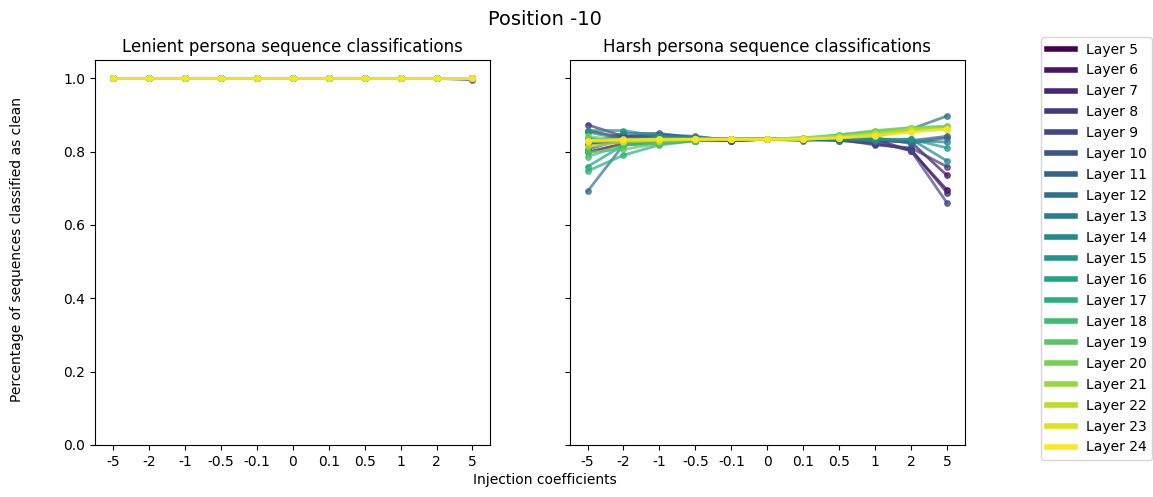

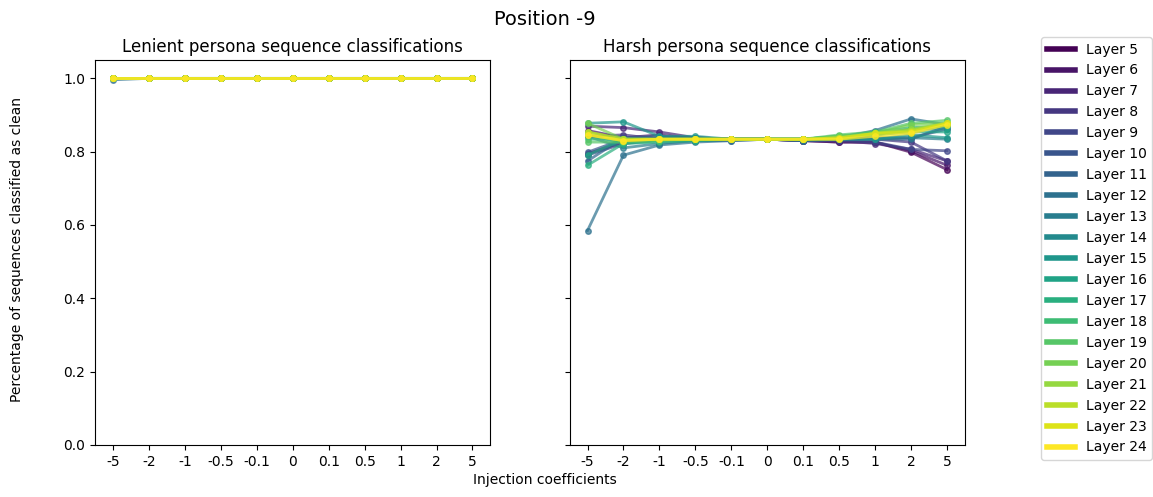

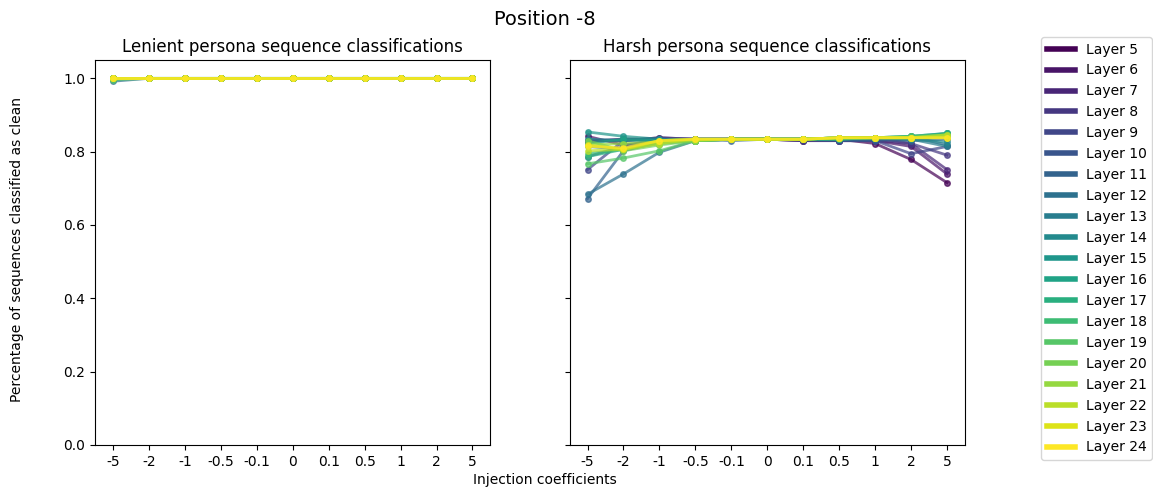

Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}


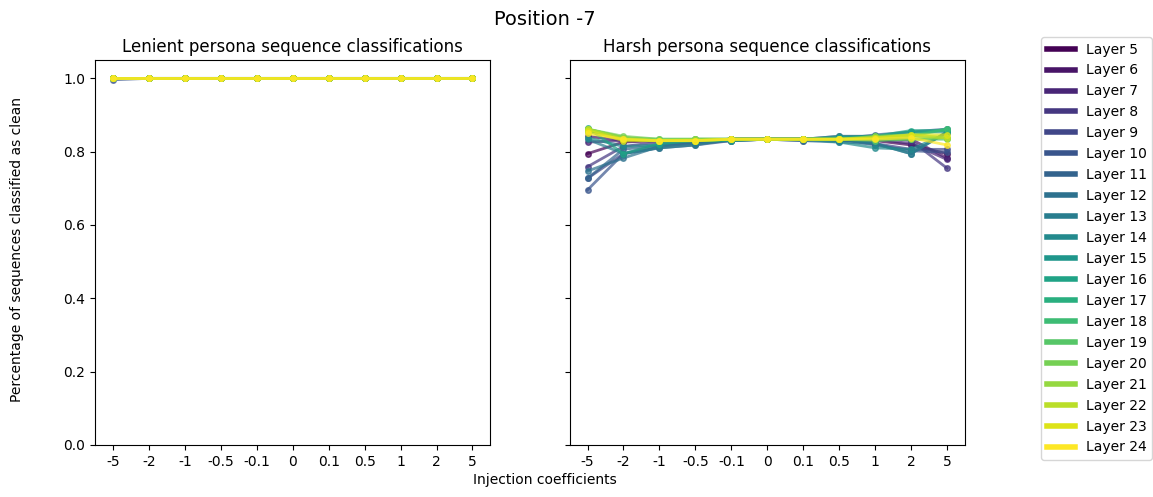

Invalid predictions! 27 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 9 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 5 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 8 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}


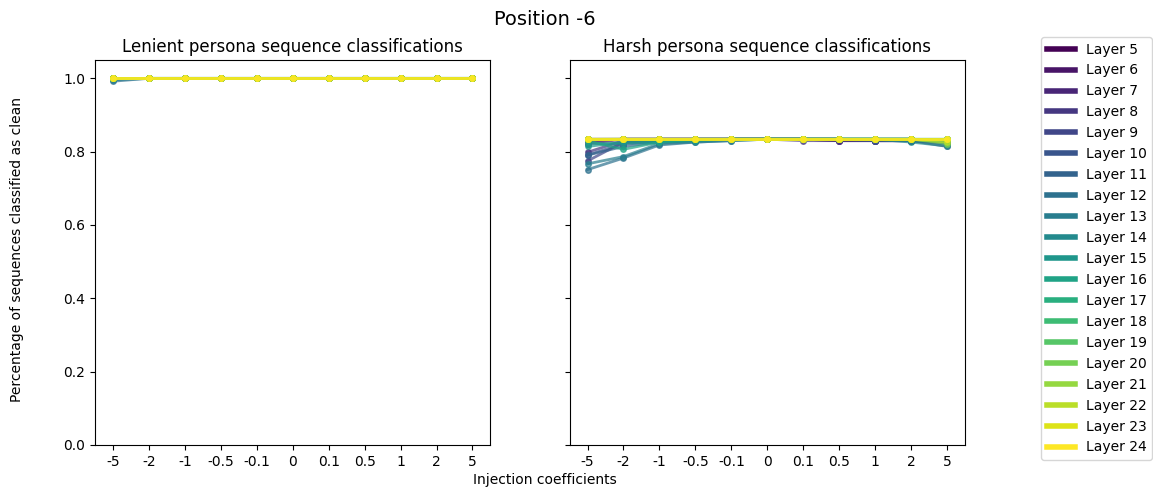

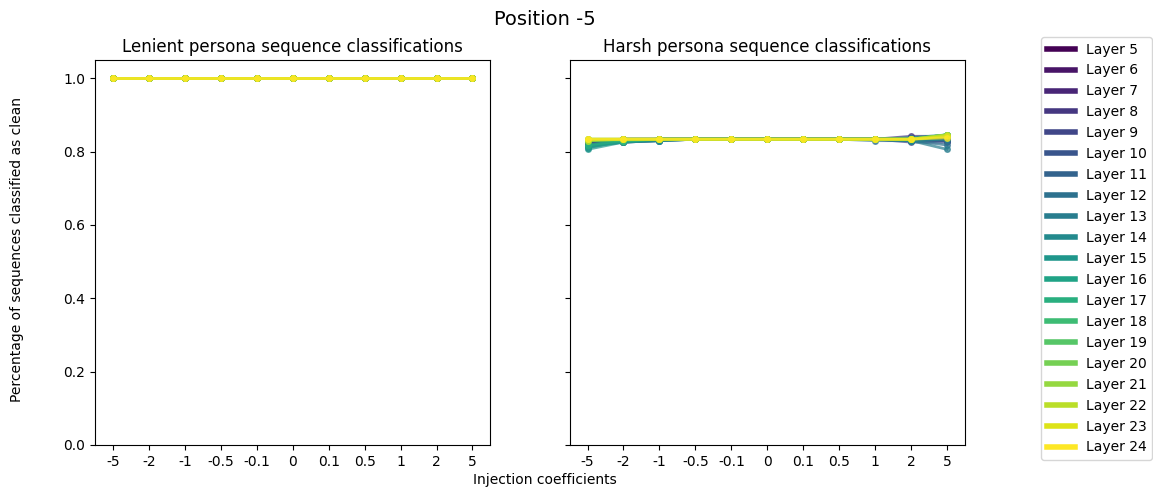

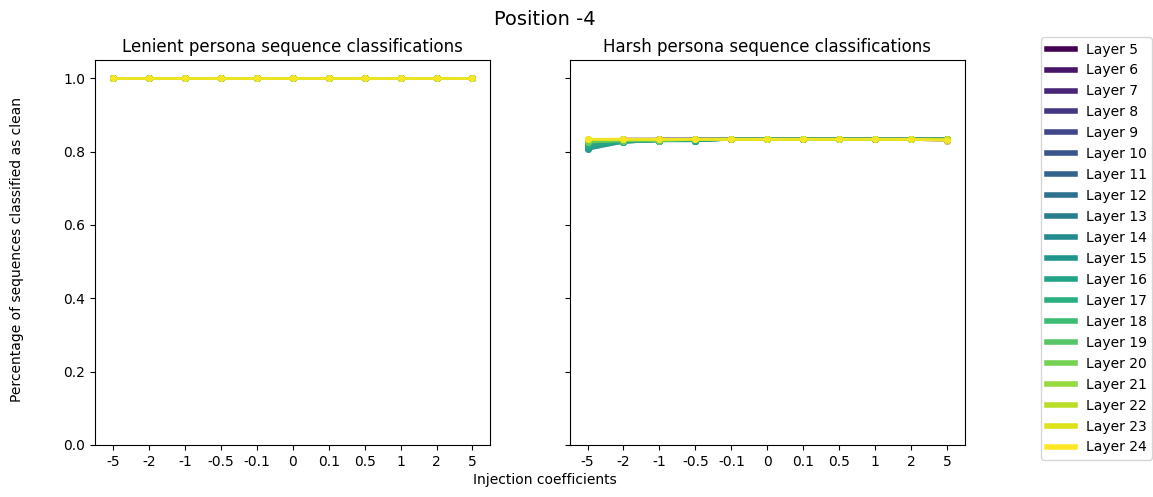

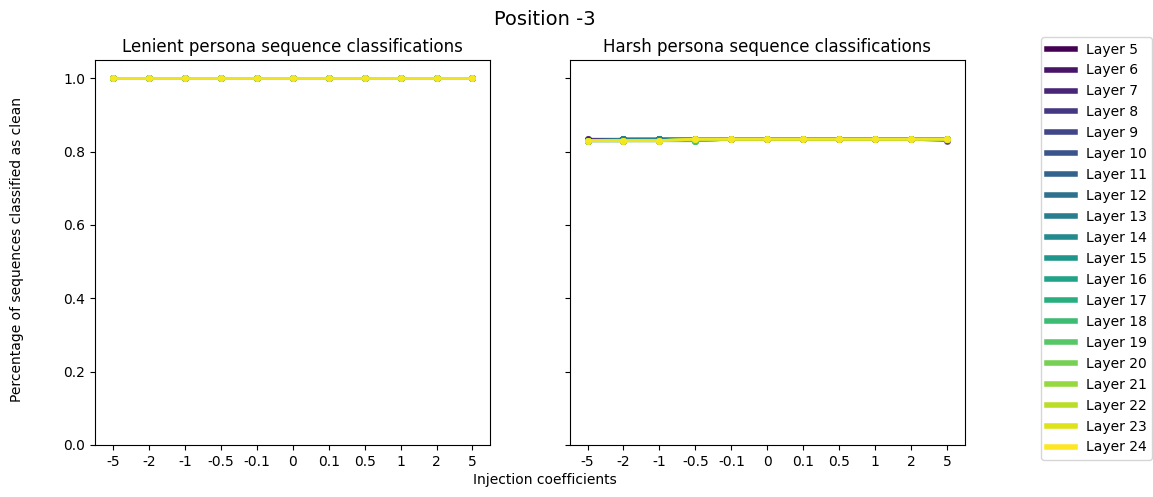

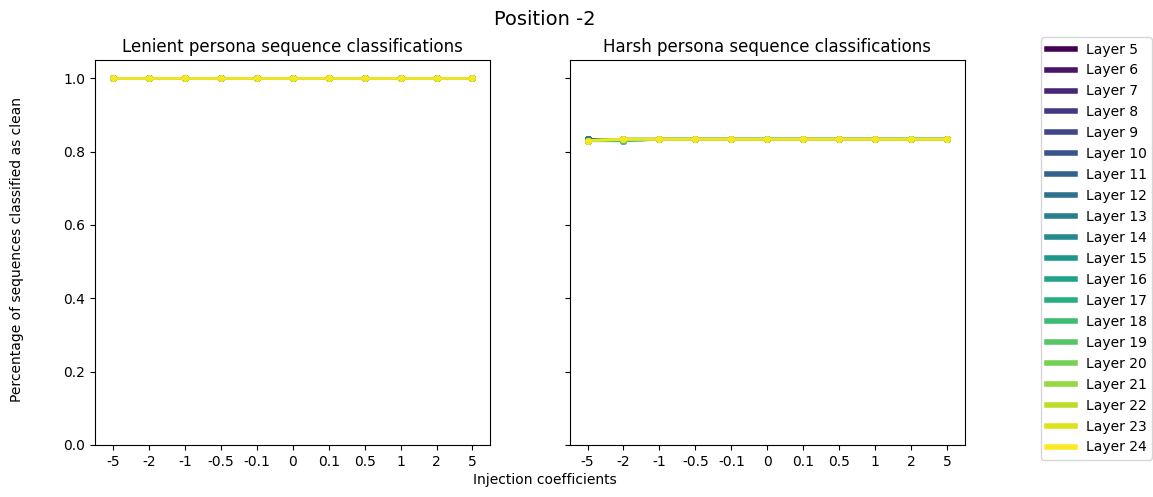

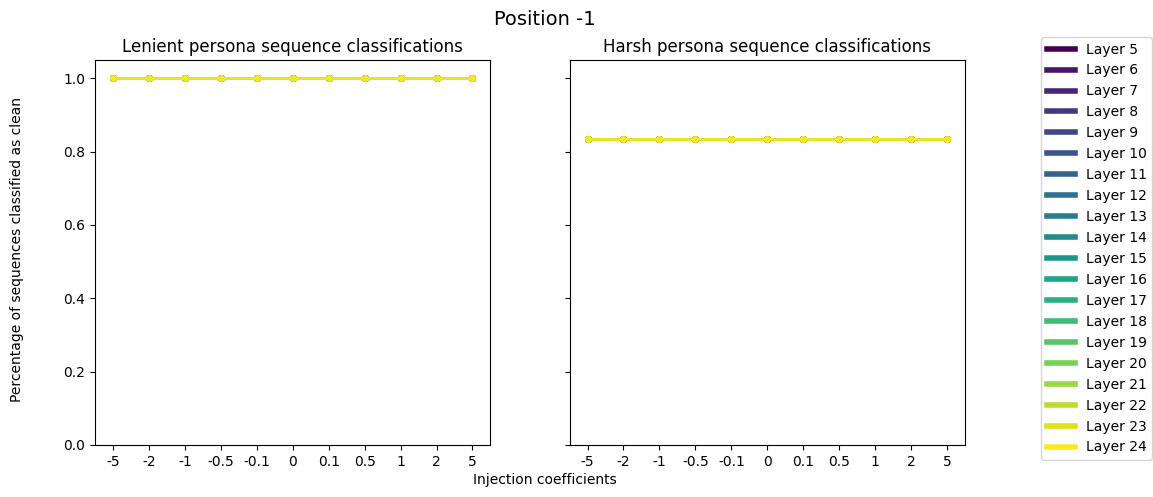

-------
Harsh results
-------


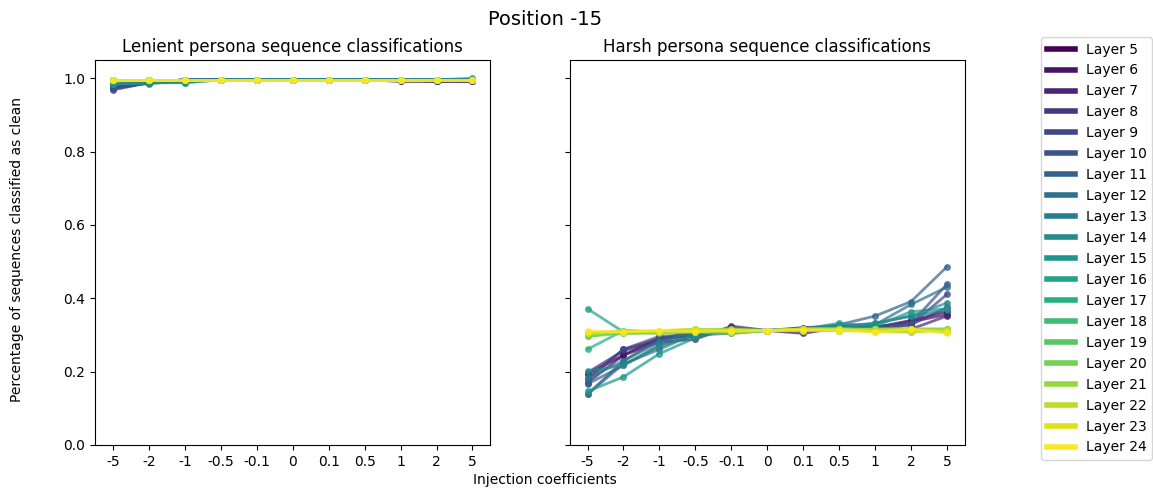

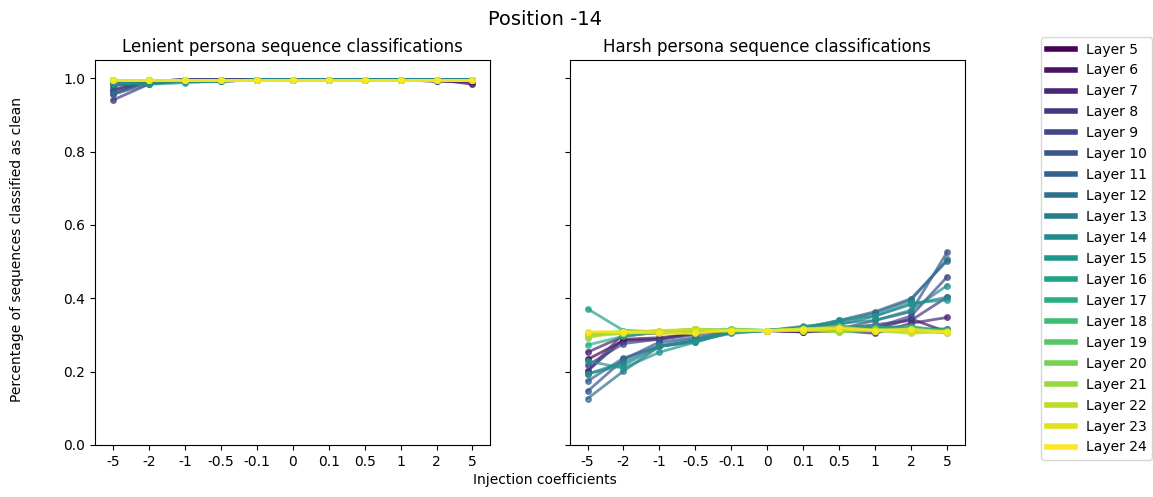

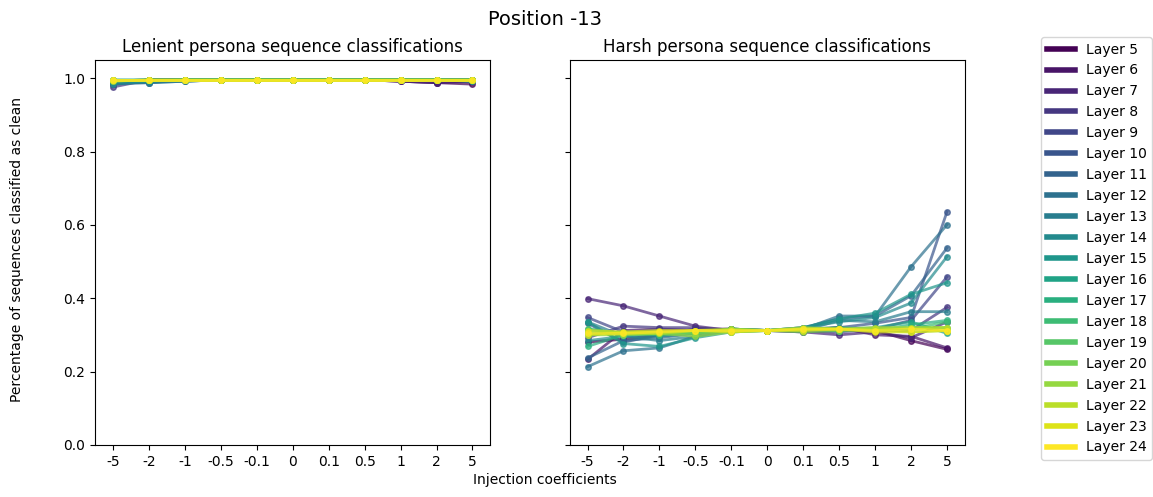

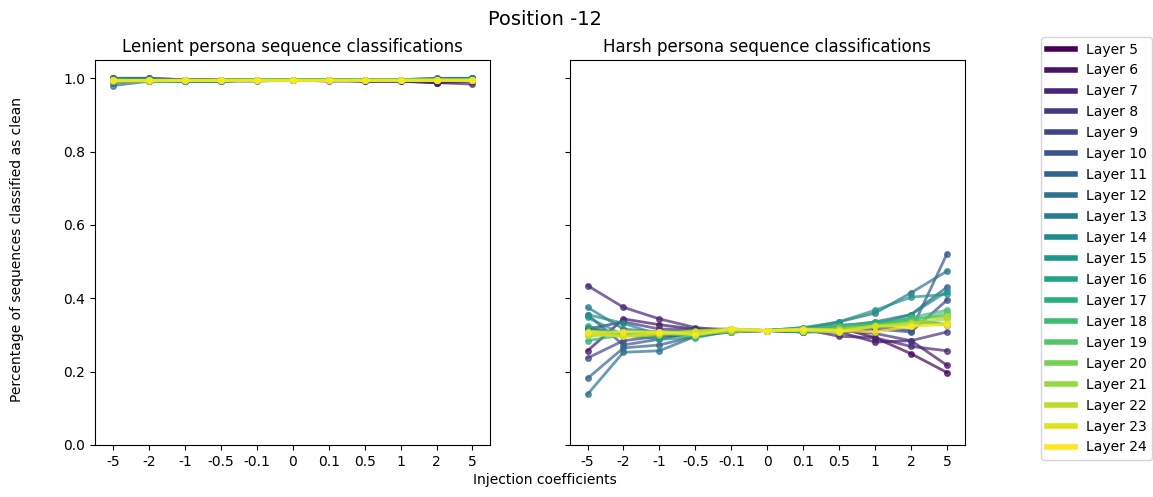

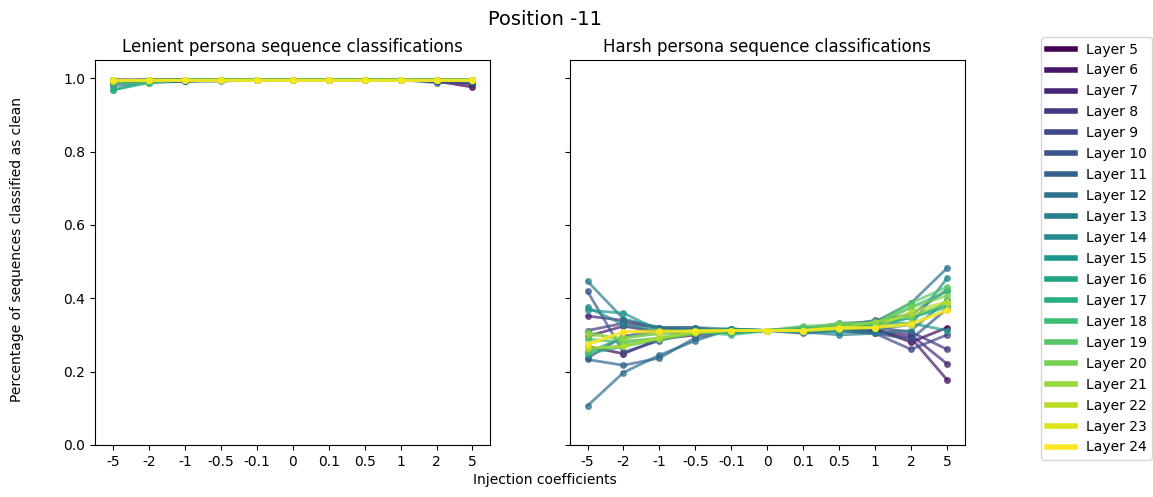

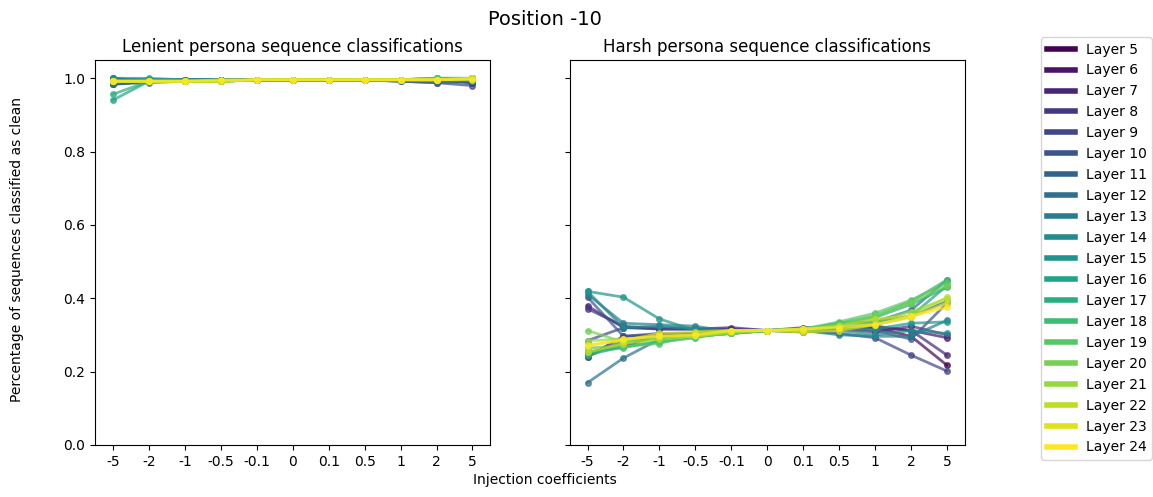

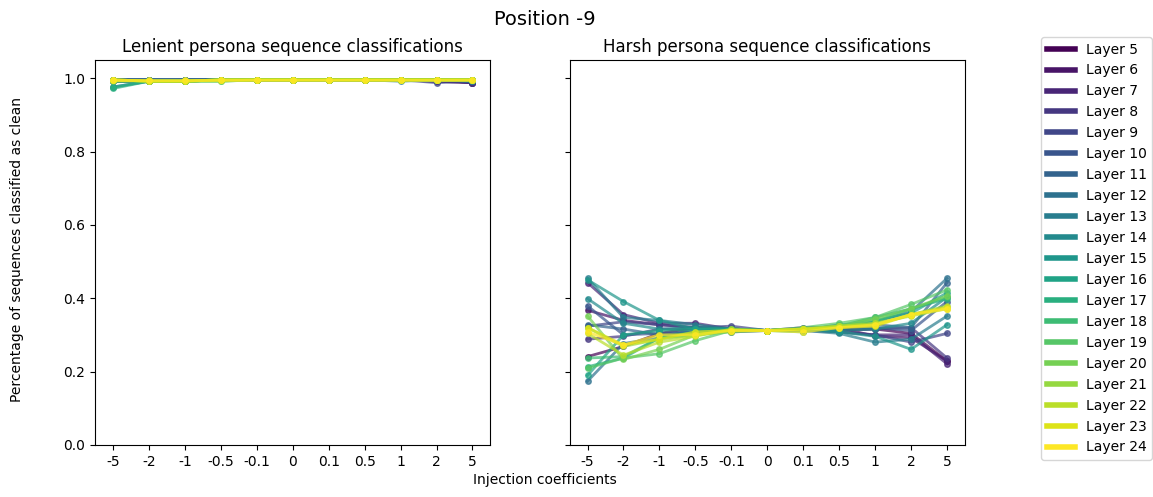

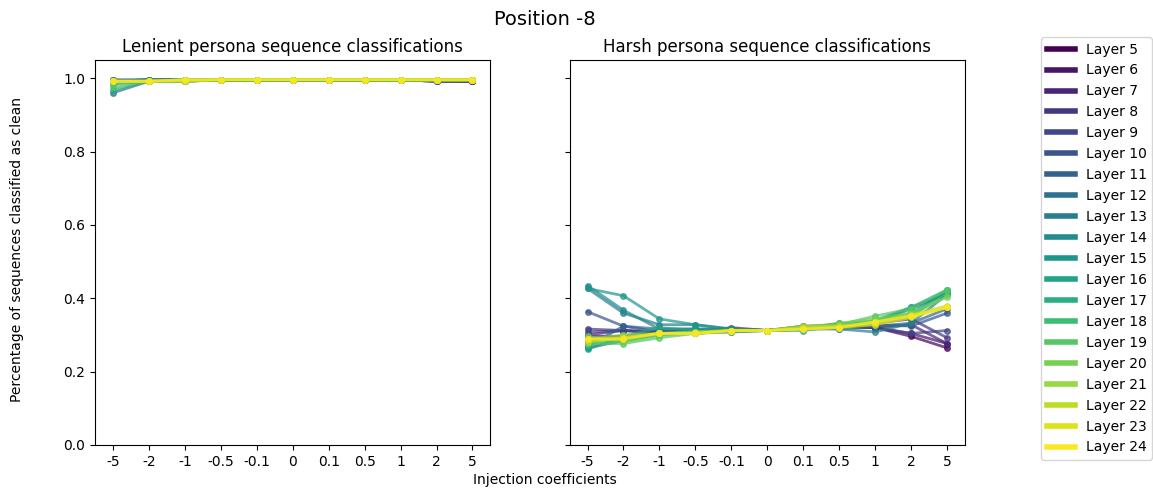

Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 3 labels is not in {CLEAN_LABEL, TOXIC_LABEL}


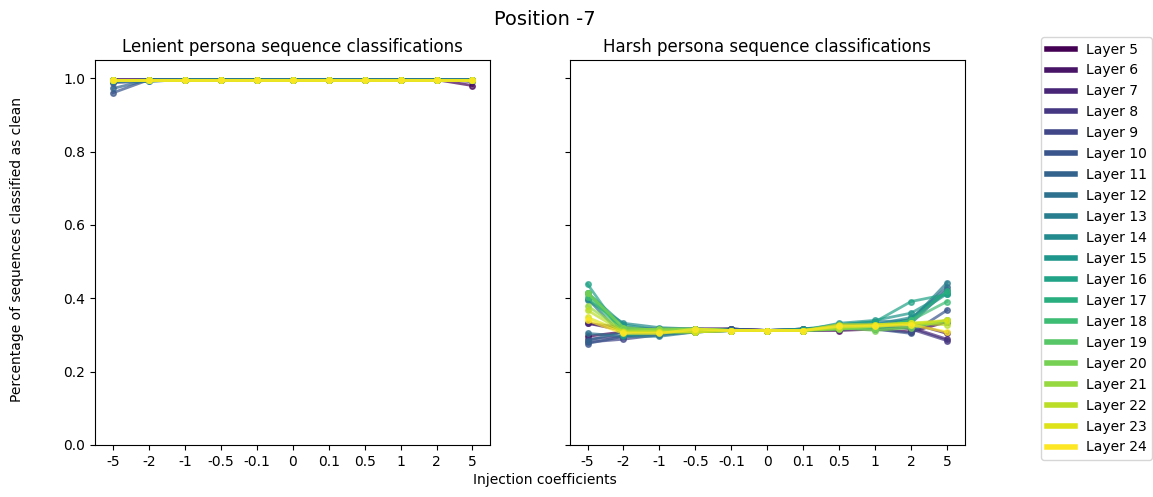

Invalid predictions! 27 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 9 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 7 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 7 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 5 labels is not in {CLEAN_LABEL, TOXIC_LABEL}
Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}


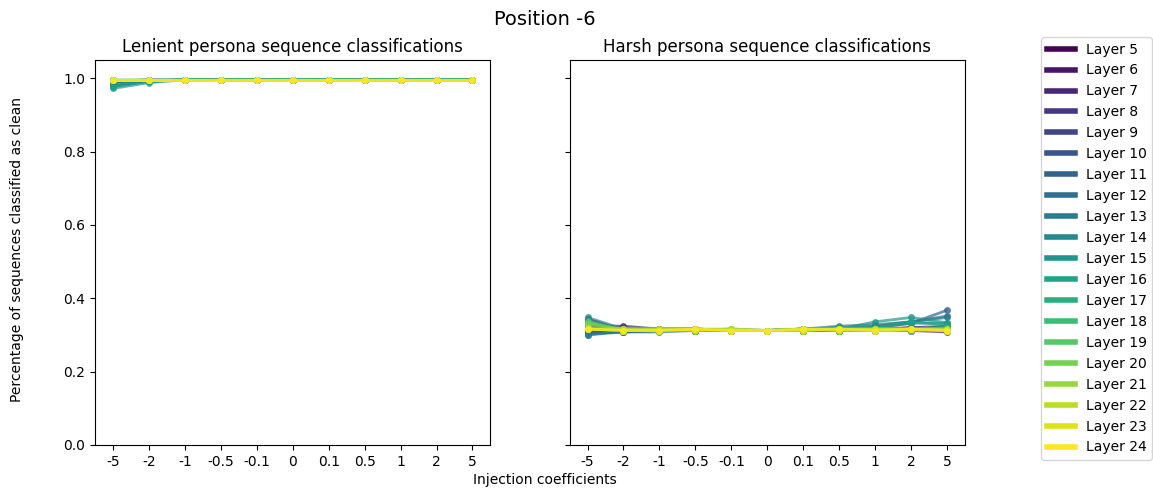

Invalid predictions! 1 labels is not in {CLEAN_LABEL, TOXIC_LABEL}


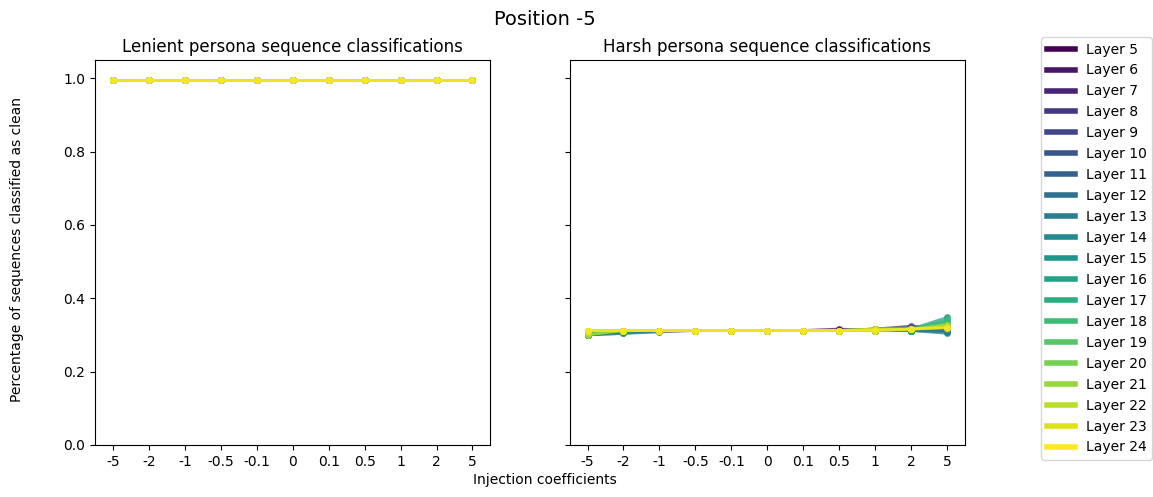

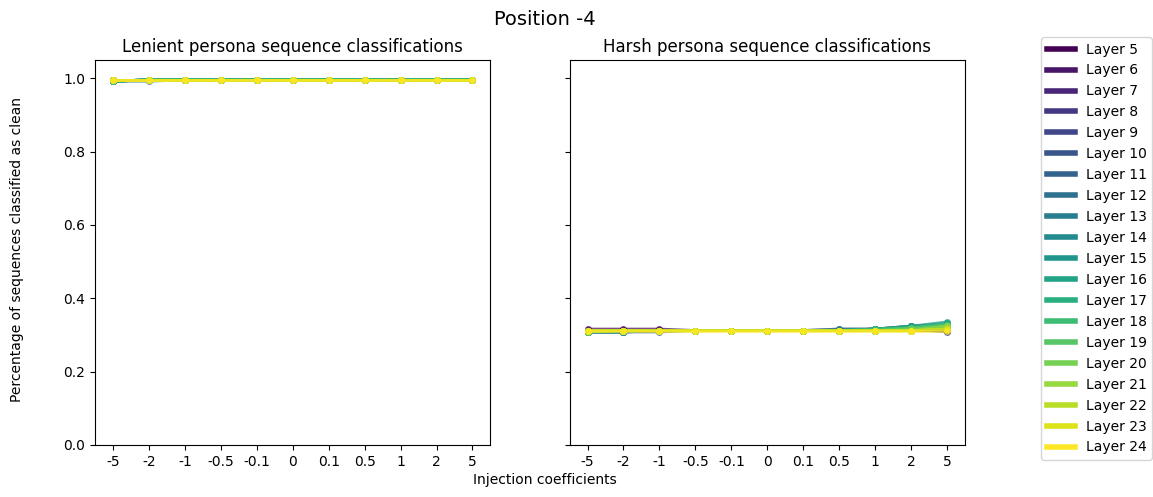

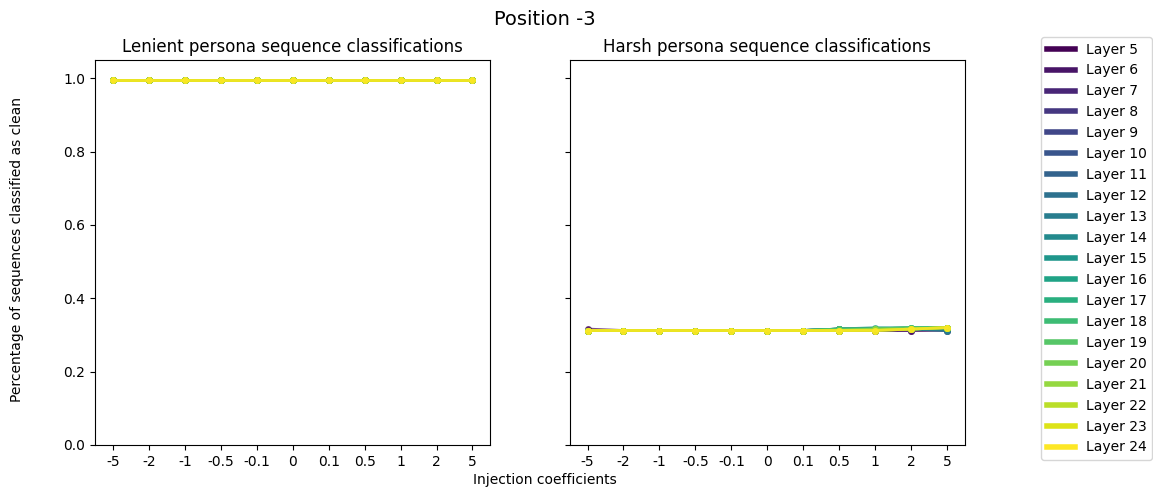

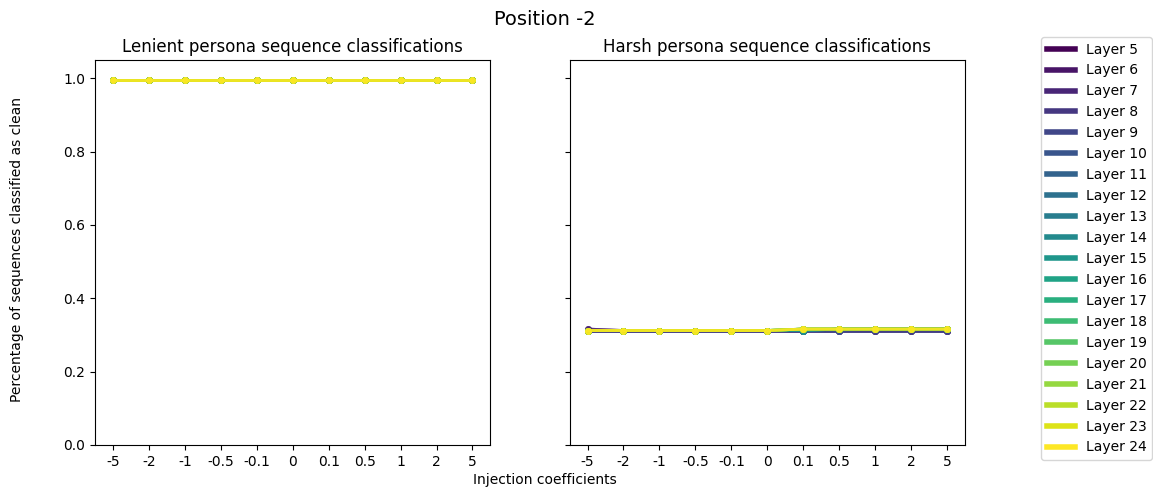

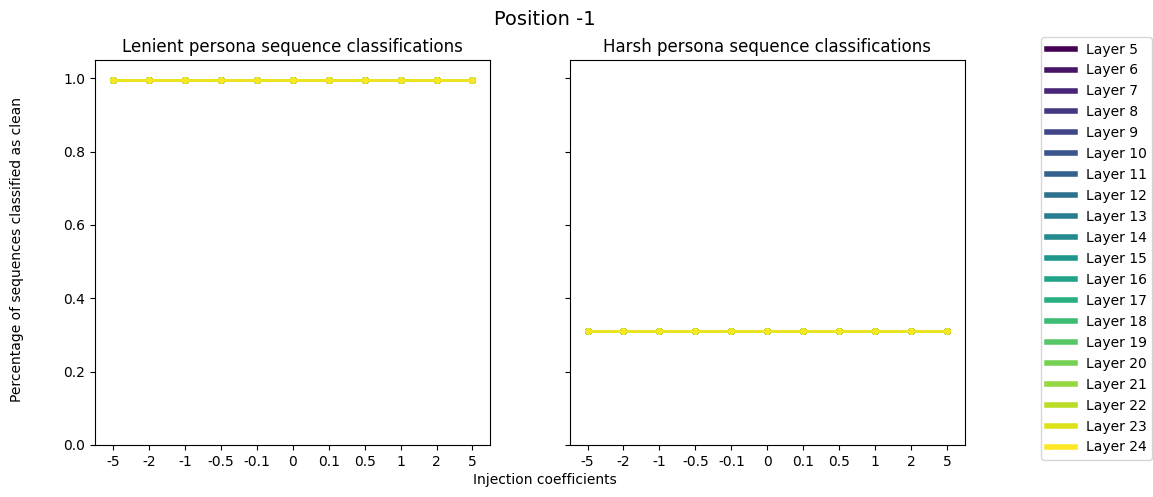

In [16]:
# position, layer, injection coefficient
print("-------\nPersona results\n-------")
results = torch.load("steering_results.pt")
plot_results(results, save_path="images/steering_vectors/persona_steering/", save=False, show=True)

print("-------\nLenient results\n-------")
lenient = torch.load("lenient_steering_results.pt")
plot_results(lenient, save_path="images/steering_vectors/lenient_sequences/", save=False, show=True)

print("-------\nHarsh results\n-------")
harsh_results = torch.load("harsh_steering_results.pt")
plot_results(harsh_results, save_path="images/steering_vectors/harsh_sequences/", save=False, show=True)

In [ ]:
torch